In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
import os

from sklearn.metrics import classification_report
import tensorflow.keras.backend as K

from tensorflow.keras import layers

E0000 00:00:1753431396.138184      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230


In [ ]:
# Config 
INPUT_DIR = Path("/kaggle/working/output_wav2vec_custom_augmented")
OUTPUT_DIR = Path("./output_cnn_class_tpu")
OUTPUT_DIR.mkdir(exist_ok=True)

MAX_SEQ_LEN = 150
EMBEDDING_DIM = 768
LABEL_COLS = ['Prolongation', 'Block', 'SoundRep', 'WordRep', 'Interjection']
NUM_CLASSES = len(LABEL_COLS)

BATCH_SIZE_PER_REPLICA = 16
EPOCHS = 400
LEARNING_RATE = 1e-4
THRESHOLD = 0.5

TRAIN_DATA_PATH = INPUT_DIR / "train_data.npz"
VAL_DATA_PATH = INPUT_DIR / "val_data.npz"
TEST_DATA_PATH = INPUT_DIR / "test_data.npz"
OUTPUT_DIR = Path("./")
BEST_MODEL_PATH = OUTPUT_DIR / "best_cnn_model.keras"


In [ ]:
print("--- Initializing TPU Strategy ---")

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu='local')
    # tf.config.experimental_connect_to_cluster(tpu)
    # tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    
    print('TPU successfully initialized. Found TPU: ', tpu.master())
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
    print(f"Global batch size set to: {BATCH_SIZE}")
    print("Number of replicas:", strategy.num_replicas_in_sync)

except Exception as e:
    print(f"TPU initialization failed, this is the error: {e}")
    print("Falling back to default strategy (CPU/GPU).")
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA


--- Initializing TPU Strategy ---
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: local


INFO:tensorflow:Initializing the TPU system: local


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


TPU successfully initialized. Found TPU:  
Global batch size set to: 128
Number of replicas: 8


In [ ]:
print("\nLoading all compressed features")

train_data = np.load(TRAIN_DATA_PATH)
val_data = np.load(VAL_DATA_PATH)
test_data = np.load(TEST_DATA_PATH)

# Access the arrays by the keys we used when saving ('x' and 'y')
X_train, y_train = train_data['x'], train_data['y']
X_val, y_val = val_data['x'], val_data['y']
X_test, y_test = test_data['x'], test_data['y']


print("All compressed data loaded successfully.")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")



Loading all compressed features
All compressed data loaded successfully.
X_train shape: (33945, 150, 768)
y_train shape: (33945, 6)


In [ ]:
# Remove the last column ('NoStutter') from the labels
y_train = y_train[:, :-1]
y_val = y_val[:, :-1]
y_test = y_test[:, :-1]

# Filter out samples that now have NO labels
train_indices = np.where(y_train.sum(axis=1) > 0)[0]
val_indices = np.where(y_val.sum(axis=1) > 0)[0]
test_indices = np.where(y_test.sum(axis=1) > 0)[0]

X_train, y_train = X_train[train_indices], y_train[train_indices]
X_val, y_val = X_val[val_indices], y_val[val_indices]
X_test, y_test = X_test[test_indices], y_test[test_indices]

print("Data loaded and modified successfully.")
print(f"New X_train shape: {X_train.shape}")


Data loaded and modified successfully.
New X_train shape: (29783, 150, 768)


In [ ]:
print("\n Verifying final training set distribution after augmentation")

final_train_labels_df = pd.DataFrame(y_train, columns=LABEL_COLS)

print("Final distribution of labels in the training set (including augmented samples):")
print(final_train_labels_df.sum().sort_values(ascending=False))



 Verifying final training set distribution after augmentation
Final distribution of labels in the training set (including augmented samples):
Block           10848
Interjection    10824
Prolongation    10800
SoundRep        10576
WordRep         10569
dtype: int64


In [ ]:
print("\nBuilding tf.data pipeline")

def prepare_dataset(X, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    ds = ds.cache()
    if shuffle:
        ds = ds.shuffle(buffer_size=2048)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = prepare_dataset(X_train, y_train, shuffle=True)
val_dataset = prepare_dataset(X_val, y_val)
test_dataset = prepare_dataset(X_test, y_test)
print("Datasets created successfully.")



Building tf.data pipeline


In [ ]:

with strategy.scope():
    print("\n--- Building 1D CNN Model inside TPU Strategy Scope... ---")

    def build_cnn_classifier(input_shape, num_classes):
        inputs = tf.keras.layers.Input(shape=input_shape)

        x = tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu")(inputs)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)

        x = tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.GlobalAveragePooling1D()(x)

        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        outputs = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)
        
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=1.0)
        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc', multi_label=True)
            ]
        )
        return model

    model = build_cnn_classifier(input_shape=(MAX_SEQ_LEN, EMBEDDING_DIM), num_classes=NUM_CLASSES)

model.summary()

checkpoint = tf.keras.callbacks.ModelCheckpoint(BEST_MODEL_PATH, monitor='val_auc', mode='max', save_best_only=True, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True)
print(f"LEARNING RATE: {LEARNING_RATE}")
print(f"BATCH SIZE: {BATCH_SIZE}")



--- Building 1D CNN Model inside TPU Strategy Scope... ---


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 150, 768)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 150, 128)       │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 150, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 75, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 75, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 428,677 (1.64 MB)

 Trainable params: 427,909 (1.63 MB)

 Non-trainable params: 768 (3.00 KB)

LEARNING RATE: 0.0001
BATCH SIZE: 128


In [22]:
print("\nStarting Training on TPU")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint, early_stopping]
)


Starting Training on TPU
Epoch 1/400


I0000 00:00:1753437838.030684      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:11507296476718487572
I0000 00:00:1753437838.791269     981 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(2375217419428416861), session_name()
I0000 00:00:1753437841.212043     981 tpu_compile_op_common.cc:245] Compilation of 2375217419428416861 with session name  took 2.420681853s and succeeded
I0000 00:00:1753437841.222976     981 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(2375217419428416861), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_11507296476718487572", property.function_library_fingerprint = 16055599253559987419, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().

232/233 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2724 - auc: 0.5989 - loss: 0.6598 - precision: 0.4458 - recall: 0.4662

I0000 00:00:1753437848.788128    1026 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(17153715300439531031), session_name()
I0000 00:00:1753437851.677534    1026 tpu_compile_op_common.cc:245] Compilation of 17153715300439531031 with session name  took 2.889351118s and succeeded
I0000 00:00:1753437851.690411    1026 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(17153715300439531031), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_11507296476718487572", property.function_library_fingerprint = 16055599253559987419, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "11,150,768,;11,5,;", property.guaranteed_constants_size = 0, embeddin

233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2725 - auc: 0.5990 - loss: 0.6597 - precision: 0.4460 - recall: 0.4660

I0000 00:00:1753437868.161495      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:15438416418290553771
I0000 00:00:1753437868.577969     990 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(17294739640873851018), session_name()
I0000 00:00:1753437869.374547     990 tpu_compile_op_common.cc:245] Compilation of 17294739640873851018 with session name  took 796.531384ms and succeeded
I0000 00:00:1753437869.377478     990 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(17294739640873851018), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_15438416418290553771", property.function_library_fingerprint = 18094291852475846732, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap


Epoch 1: val_auc improved from -inf to 0.68049, saving model to best_cnn_model.keras
233/233 ━━━━━━━━━━━━━━━━━━━━ 47s 126ms/step - accuracy: 0.2726 - auc: 0.5992 - loss: 0.6596 - precision: 0.4462 - recall: 0.4658 - val_accuracy: 0.1767 - val_auc: 0.6805 - val_loss: 0.6755 - val_precision: 0.4528 - val_recall: 0.3712
Epoch 2/400
232/233 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3383 - auc: 0.6842 - loss: 0.6045 - precision: 0.5665 - recall: 0.4051
Epoch 2: val_auc improved from 0.68049 to 0.70039, saving model to best_cnn_model.keras
233/233 ━━━━━━━━━━━━━━━━━━━━ 37s 102ms/step - accuracy: 0.3383 - auc: 0.6843 - loss: 0.6044 - precision: 0.5667 - recall: 0.4052 - val_accuracy: 0.1782 - val_auc: 0.7004 - val_loss: 0.6612 - val_precision: 0.5058 - val_recall: 0.4187
Epoch 3/400
231/233 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3551 - auc: 0.6974 - loss: 0.6002 - precision: 0.5946 - recall: 0.4046
Epoch 3: val_auc improved from 0.70039 to 0.70877, saving model to best_cnn_mode


--- Evaluating Model on the Test Set ---


I0000 00:00:1753438877.920632      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:3547500655100514906
E0000 00:00:1753438877.932075      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_3_1/batch_normalization_6_1/Cast/ReadVariableOp.
I0000 00:00:1753438877.980623    1013 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(652731131681445757), session_name()
I0000 00:00:1753438878.236644    1013 tpu_compile_op_common.cc:245] Compilation of 652731131681445757 with session name  took 255.946558ms and succeeded
I0000 00:00:1753438878.238099    1013 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(652731131681445757), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_3547500655100514906", property.function_library_fingerprint = 10857609729014403383, property.mlir_module_

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step

I0000 00:00:1753438883.089991      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:327644504857647645
I0000 00:00:1753438883.223394    1031 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(3483495641445147356), session_name()
I0000 00:00:1753438883.722775    1031 tpu_compile_op_common.cc:245] Compilation of 3483495641445147356 with session name  took 499.326987ms and succeeded
I0000 00:00:1753438883.724324    1031 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(3483495641445147356), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_327644504857647645", property.function_library_fingerprint = 16847009011194349072, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology

55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 164ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.55      0.68      0.61      2613
       Block       0.69      0.25      0.37      3501
    SoundRep       0.56      0.53      0.55      1891
     WordRep       0.66      0.26      0.37      1742
Interjection       0.89      0.57      0.70      3344

   micro avg       0.66      0.46      0.54     13091
   macro avg       0.67      0.46      0.52     13091
weighted avg       0.69      0.46      0.53     13091
 samples avg       0.58      0.47      0.49     13091


--- Generating plots for model training history... ---


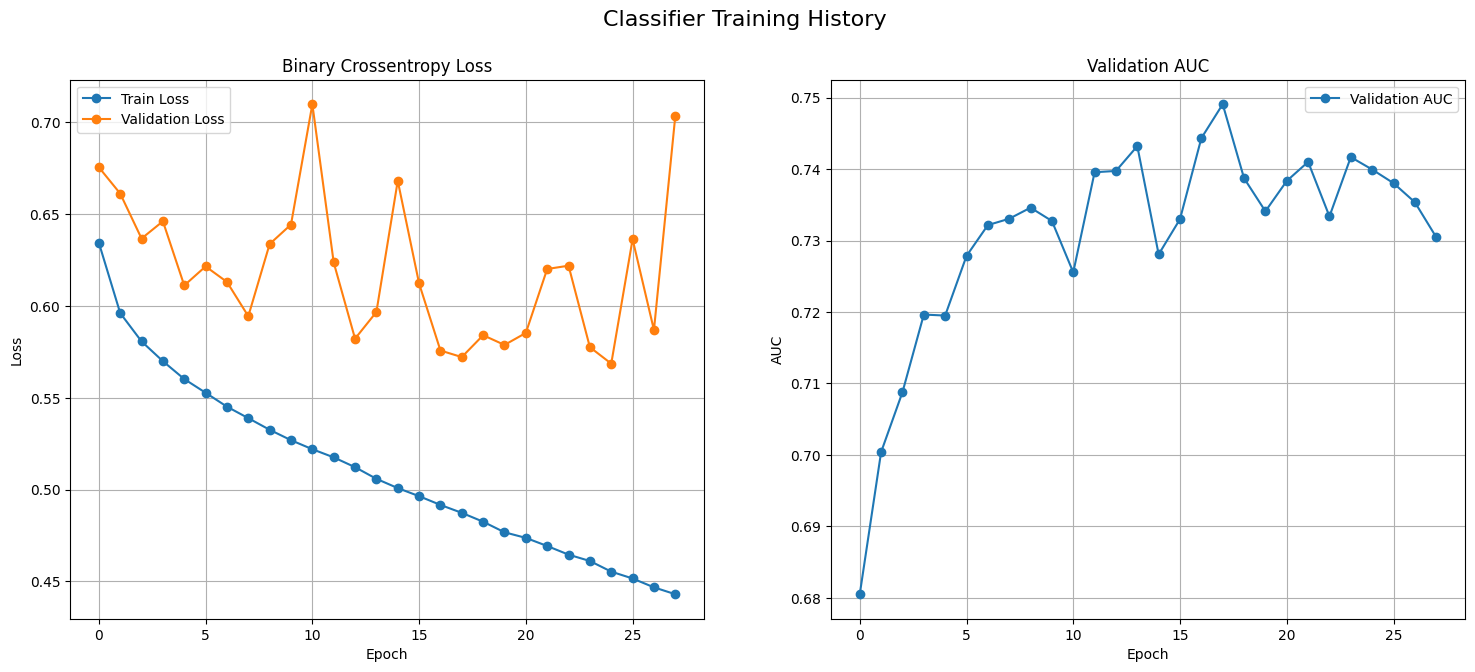

In [ ]:

from sklearn.metrics import multilabel_confusion_matrix, precision_recall_curve, average_precision_score
import itertools

print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred_binary = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred_binary)
y_test_eval = y_test[:num_predictions]

print("\n--- Classification Report (5 Stuttering Classes) ---")
report = classification_report(y_test_eval, y_pred_binary, target_names=LABEL_COLS, zero_division=0)
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Classifier Training History', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Binary Crossentropy Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc'], 'o-', label='Validation AUC')
ax2.set_title('Validation AUC'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history.png")
plt.show()